## Keras denoising autoencoder

Modified version from keras example: https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

Using TensorFlow backend.


In [3]:
import datetime
import models
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import preprocess

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

In [4]:
print('Running YASS version: '+yass_util.get_version())

Running YASS version: 5c928a5 bug


In [5]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [6]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [7]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

# remove spikes at the beginning (2) and end (1) to avoid errors
# when getting waveforms
gt = gt[2:-1]

# shift ids to start at 0
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
gt[:, 0] = gt[:, 0] + 10

In [8]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

In [9]:
# use all templates
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

# chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11,
#                     12, 13, 14, 15, 16, 17, 18, 19,
#                     22, 23, 24, 25, 26, 27, 28, 29,
#                     30, 31, 32, 33, 34, 35, 36, 37,
#                     38, 39, 41, 42, 43, 44, 45, 46,
#                     47, 48]

In [10]:
templates, _ = preprocess(CONFIG, gt,
                          path_to_standarized,
                          chosen_templates,
                          crop_spatially=False)


100%|██████████| 3/3 [00:09<00:00,  3.13s/it]


In [11]:
templates.shape

(41, 61, 49)

In [12]:
min_amplitude = 5
max_amplitude = 15
n_clean_per_template = 30


test_set = evaluate.TestSet(10, templates,
                            min_amplitude, max_amplitude,
                            path_to_standarized,
                            n_clean_per_template,
                            CONFIG.geom)

In [13]:
test_set.stats

{'from templates': 1230,
 'spatially misaligned': 1230,
 'temporally misaligned': 1230,
 'collided': 1230,
 'zero': 1230}

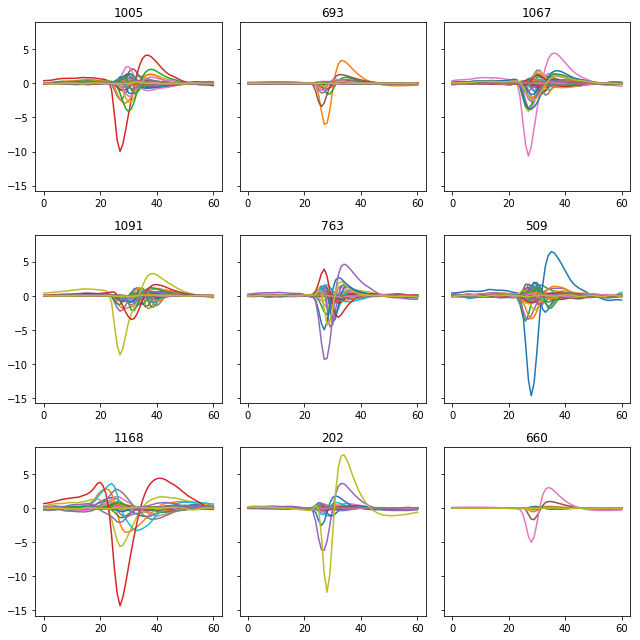

In [14]:
plot.grid_from_array(test_set.get_kind_clean('from templates'),
                     axis=0, elements=9,
                     auto_figsize=3, sharey=True)

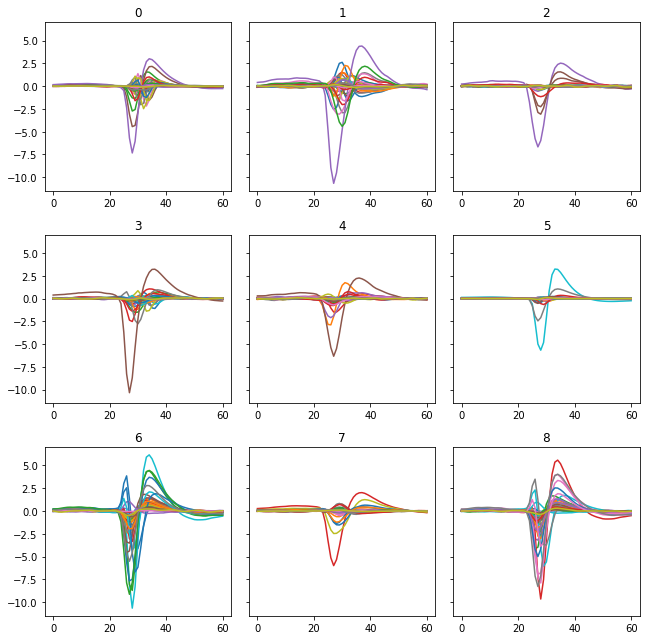

In [15]:
plot.grid_from_array(test_set.get_kind_clean('spatially misaligned'),
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

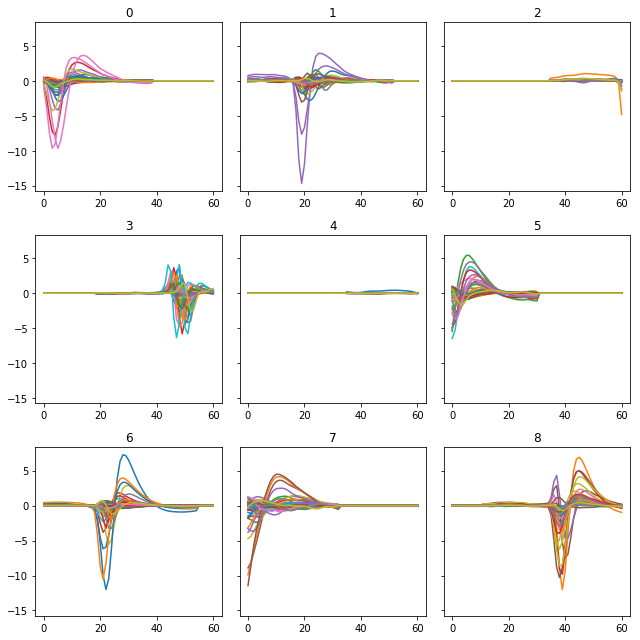

In [16]:
plot.grid_from_array(test_set.get_kind_clean('temporally misaligned'),
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

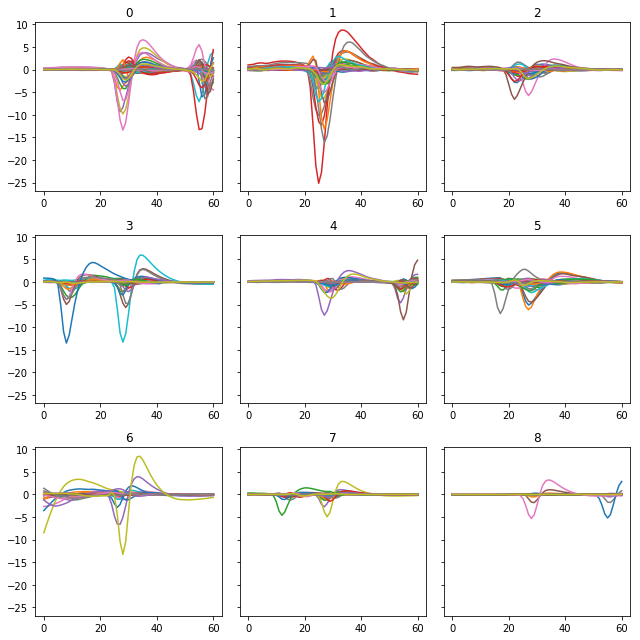

In [17]:
plot.grid_from_array(test_set.get_kind_clean('collided'),
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

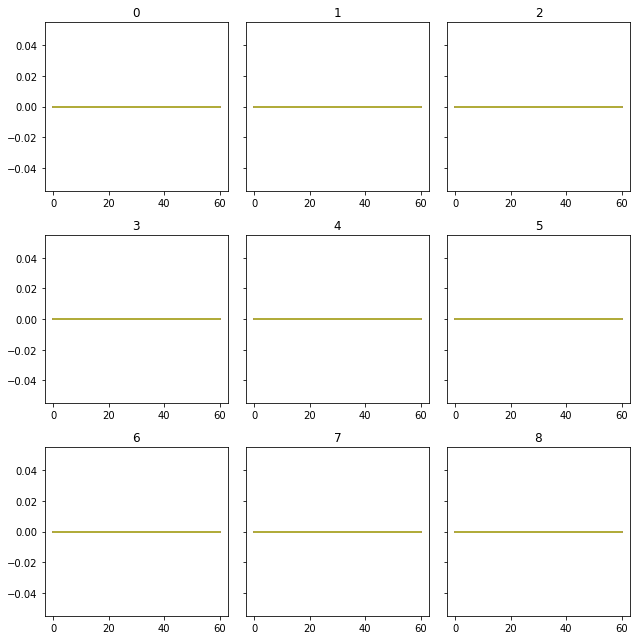

In [18]:
plot.grid_from_array(test_set.get_kind_clean('zero'),
                     axis=0, elements=range(9),
                     auto_figsize=3, sharey=True)

## Generating train and test sets

In [19]:
kinds = ('collided', 'zero', 'temporally misaligned',
         'spatially misaligned', 'from templates')
data_noisy = test_set.get_kind_noisy(kinds)
data_clean = test_set.get_kind_clean(kinds)

(x_train_noisy,
 x_train_clean,
 x_test_noisy,
 x_test_clean) = evaluate.split(data_noisy, data_clean,
                                train_proportion=0.7)

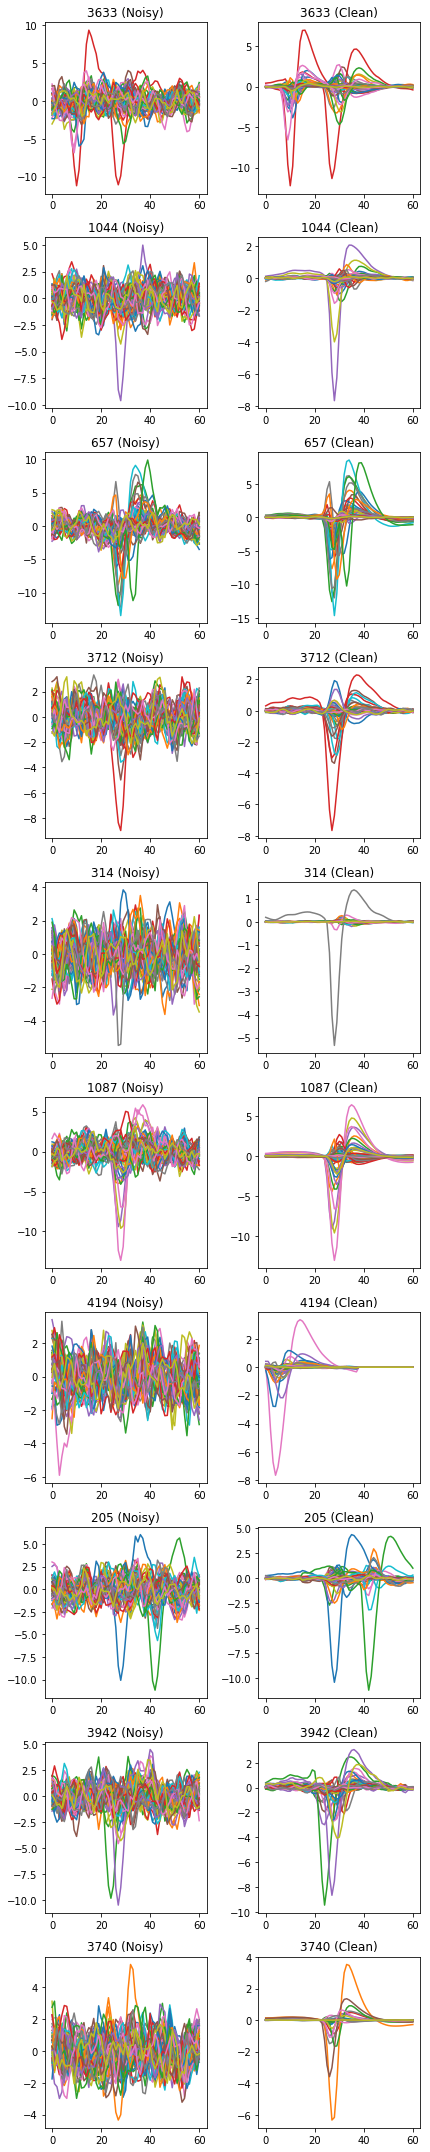

In [20]:
plot.grid_from_array([x_train_noisy, x_train_clean],
                     axis=0,
                     elements=10,
                     group_names=('Noisy', 'Clean'),
                     auto_figsize=3)

In [21]:
n_spikes, waveform_length, n_neighbors = x_train_clean.shape

# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 128
kernel_size = 3
latent_dim = 32

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)


outputs = Activation('linear', name='decoder_output')(x)

# outputs = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 49, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 49, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 49, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 191296)            0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                6121504   
Total params: 6,140,320
Trainable params: 6,140,320
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


## Training

In [22]:
# Train or loadthe autoencoder
# model_to_load = '25-Jul-2018@23-49-01.h5'
model_to_load = None

# Training parameters
epochs = 10
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2)]

if model_to_load:
    autoencoder = load_model(model_to_load)
    print('Loaded {}'.format(model_to_load))
else:
    autoencoder.fit(x_train_noisy[:, :, :, np.newaxis],
                x_train_clean[:, :, :, np.newaxis],
                validation_data=(x_test_noisy[:, :, :, np.newaxis],
                                 x_test_clean[:, :, :, np.newaxis]),
                epochs=epochs,
                callbacks=callbacks,
                batch_size=batch_size)
    name = reproducibility.make_filename('h5')
    autoencoder.save(name)
    print('Saved {}'.format(name))

Train on 4305 samples, validate on 1845 samples
Epoch 1/10
4305/4305 [==============================] - 10s 2ms/step - loss: 0.2996 - val_loss: 0.2710
Epoch 2/10
4305/4305 [==============================] - 7s 2ms/step - loss: 0.2357 - val_loss: 0.2007
Epoch 3/10
4305/4305 [==============================] - 7s 2ms/step - loss: 0.1806 - val_loss: 0.1649
Epoch 4/10
4305/4305 [==============================] - 7s 2ms/step - loss: 0.1567 - val_loss: 0.1473
Epoch 5/10
4305/4305 [==============================] - 7s 2ms/step - loss: 0.1406 - val_loss: 0.1351
Saved 26-Jul-2018@16-34-52.h5


## Denoising (simulated) patches


In [23]:
def predict(model, x):
    x = x[:, :, :, np.newaxis]
    predictions = model.predict(x)
    return np.squeeze(predictions)

In [24]:
x_test_denoised = predict(autoencoder, np.squeeze(x_test_noisy))

In [25]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

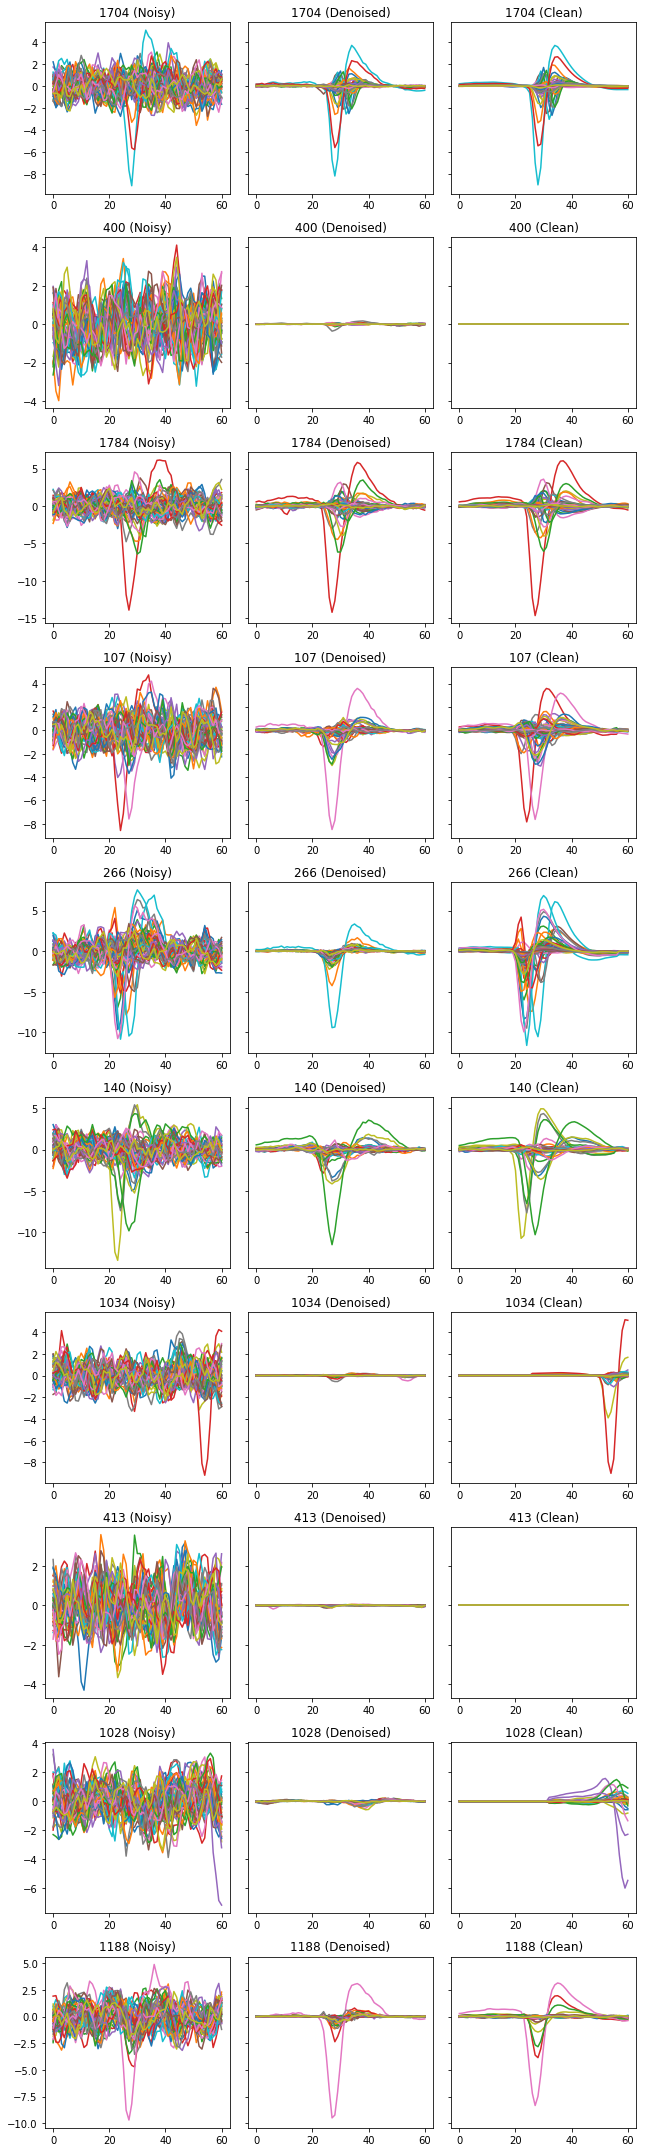

In [26]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      np.squeeze(x_test_clean)],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Clean'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

In [38]:
def plot_from_indexes(dataset, model, idxs):
    sub_noisy = np.stack(test_set.df_noisy[idxs].waveform.values)
    sub_clean = np.stack(test_set.df_clean[idxs].waveform.values)
    sbu_denoised = predict(model, sub_clean)

    plot.grid_from_array([sub_noisy,
                          sbu_denoised,
                          sub_clean],
                         axis=0,
                         group_names=('Noisy', 'Denoised', 'Clean'),
                         elements=5,
                         figsize=(10, 10),
                         sharey='row')

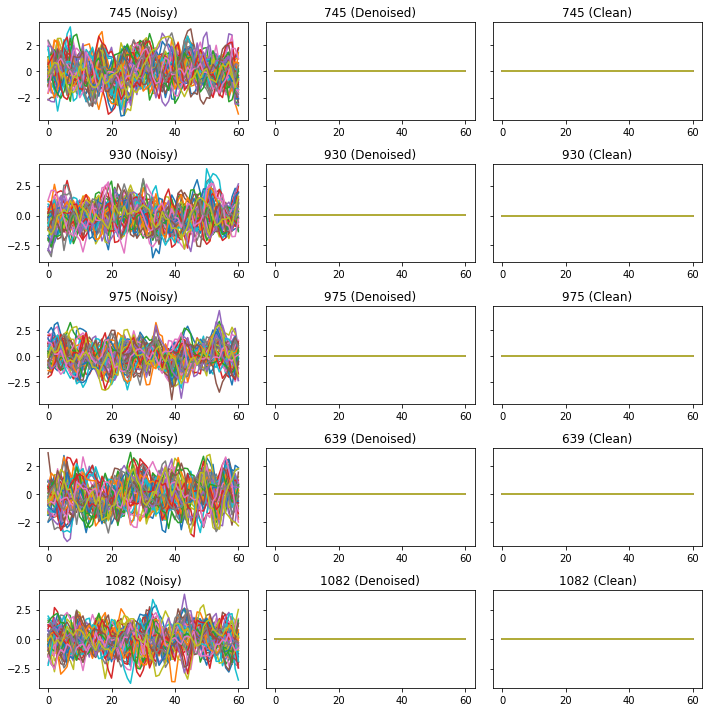

In [39]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'zero')

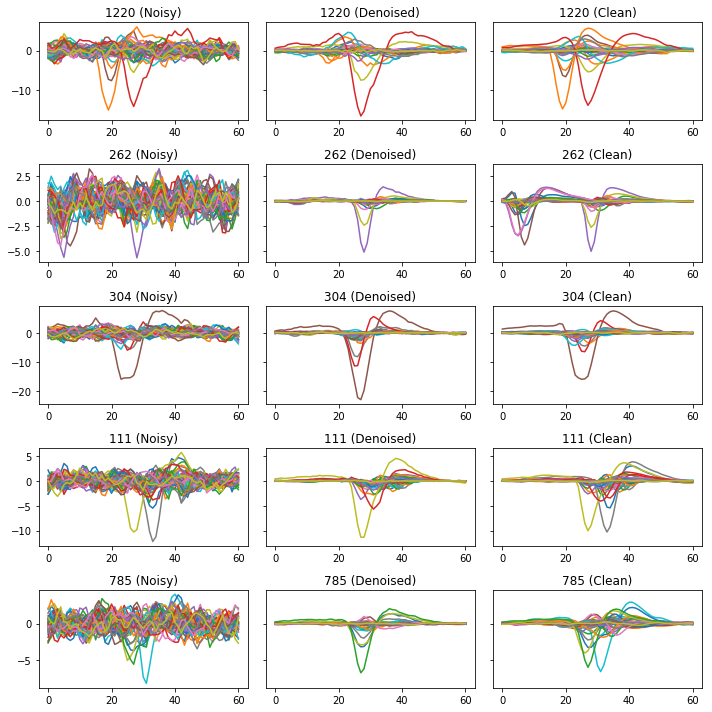

In [40]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'collided')

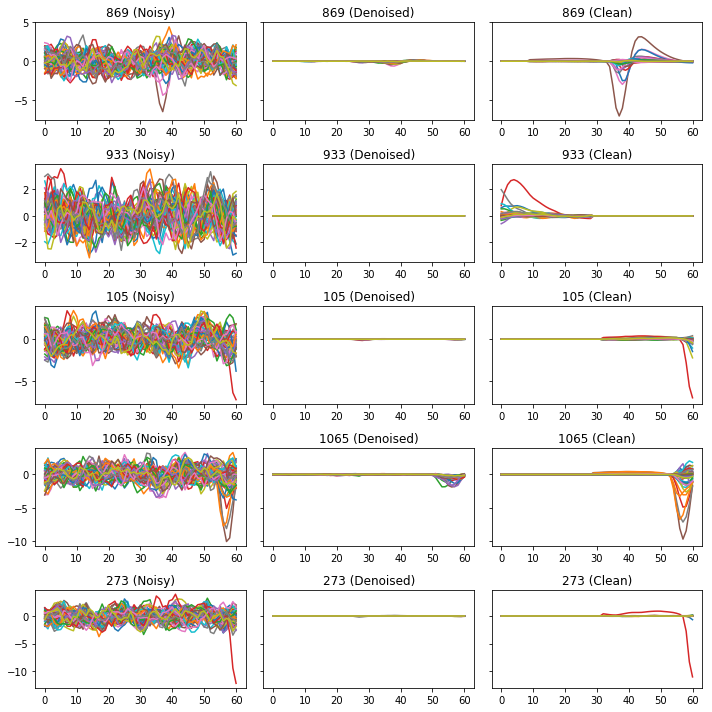

In [41]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'temporally misaligned')

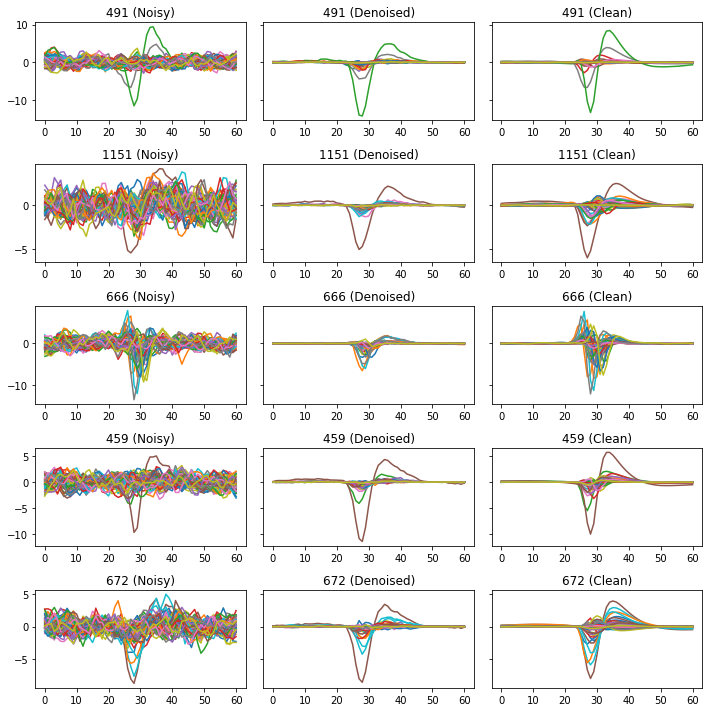

In [42]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'spatially misaligned')

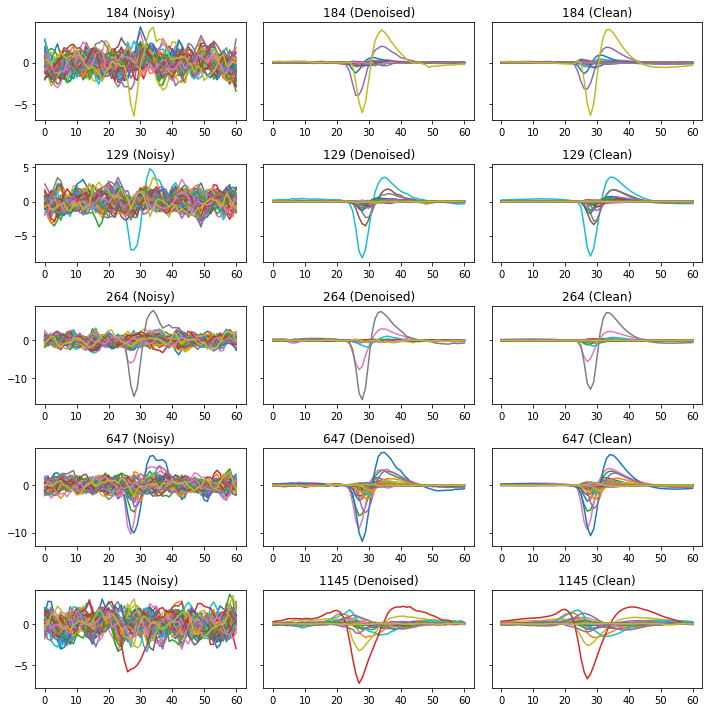

In [43]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'from templates')

## Denoising (real) patches

## Denoising recordings

In [ ]:
exp = RecordingExplorer(path_to_standarized)

In [ ]:
patch_size = 61
n_patches = 5

In [ ]:
idxs = [(n * patch_size, (n + 1) * patch_size) for n in range(n_patches)]

In [ ]:
# TODO: performance improvement, read a lot of patches and send them to .predict
processed = np.zeros((patch_size * n_patches, 49))

for from_, to_ in idxs:
    patch = exp.reader[from_:to_, :][np.newaxis, :, :, np.newaxis]
    processed[from_:to_, :] = np.squeeze(autoencoder.predict(patch))

In [ ]:
_ = plt.plot(processed)

In [ ]:
_ = plt.plot(exp.reader[:to_])